# Kyle Model

Natasha Watkins

If slope is small, market makers are concerned about presence of informed traders. Want price to be very sensitive to quantity.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
AAPL = pd.read_pickle('AAPL.pkl')
C = pd.read_pickle('C.pkl')
SPY = pd.read_pickle('SPY.pkl')
GBX = pd.read_pickle('GBX.pkl')
THO = pd.read_pickle('THO.pkl')
tickers = [AAPL, C, SPY, GBX, THO]

Part 1)

I didn't use a class because I'm not really a fan of OOP for most applications

In [3]:
def find_orderbooks(data):
    # Returns a list of arrays that contain an orderbook of prices, 
    # quantities and sell/buy type at time t
    
    orderbooks = []

    for t in range(data.shape[0]):
        quantities = [(tuple_item[0]) for tuple_item in data.iloc[t, 1].values()]
        types = np.array([tuple_item[1] for tuple_item in data.iloc[t, 1].values()])
        types = types == 'B'  # 1 if buy, 0 if sell
        prices = list(data.iloc[t, 1].keys())
        PQ = np.array([prices, quantities, types]).T
        orderbooks.append(PQ)
        
    return orderbooks

In [4]:
def supply_demand(orderbook):
    # Finds the supply and demand curves given an orderbook
    
    orderbook = pd.DataFrame(orderbook, columns=['Price', 'Quantity', 'Type'])
    
    demand = orderbook[orderbook.Type == 1].sort_values('Price', ascending=False)
    supply = orderbook[orderbook.Type == 0].sort_values('Price')
    
    demand['Qd'] = -demand.Quantity.cumsum()
    supply['Qs'] = supply.Quantity.cumsum()
    
    return supply, demand

In [5]:
def find_market(orderbook):
    # Finds the equilibrium price of a market and cuts 
    # the market to be centred around the equilibrium price
    
    supply, demand = supply_demand(orderbook)
    market = pd.concat([demand, supply])
    market = market.fillna(0)
    market['Q'] = market['Qd'] + market['Qs']  # Find quantity at each price
    
    p_star = market[market.Q < 0].Price.values[0]  # Equilibrium price (where supply meets demand (intersects the x axis))
    
    market = market[(market.Price > 0.9 * p_star) & (market.Price < 1.1 * p_star)]
    
    return market, p_star

In [6]:
def estimate_equation(orderbook):
    # Fits a least squares regression line to the market

    market, p_star = find_market(orderbook)
    market['constant'] = 1
    
    P = market[['constant', 'Price']]
    y = market['Q']
    γ, β = np.linalg.lstsq(P, y, rcond=None)[0]
    
    return γ, β, p_star

In [23]:
def plot_orderbook(orderbook):
    # Plots quantity vs. price of a market
    
    supply, demand = supply_demand(orderbook)
    
    γ, β, p_star = estimate_equation(orderbook)
    
    P_grid = np.linspace(0.9 * p_star, 1.1 * p_star)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    demand.plot('Price', 'Qd', ax=ax, label='Quantity demanded')
    supply.plot('Price', 'Qs', ax=ax, label='Quantity supplied')
    ax.plot(P_grid, γ + β * P_grid)
    plt.xlim(0.5 * p_star, 1.5 * p_star)
    plt.ylabel('Units available')
    plt.legend(loc='upper right')
    plt.show()

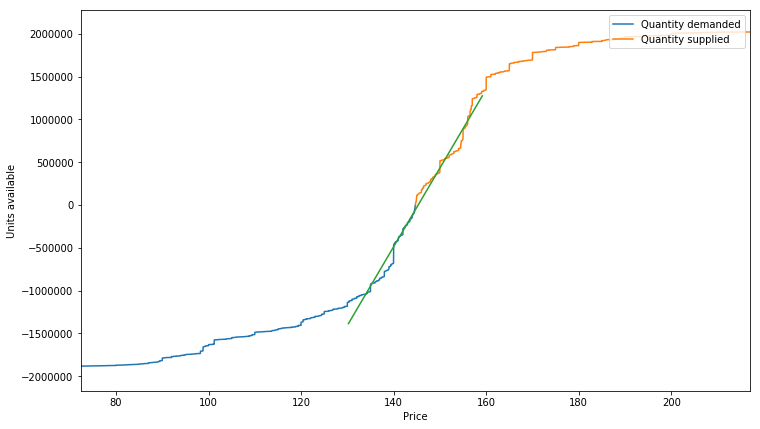

In [24]:
AAPL_orderbooks = find_orderbooks(AAPL)
plot_orderbook(AAPL_orderbooks[0])

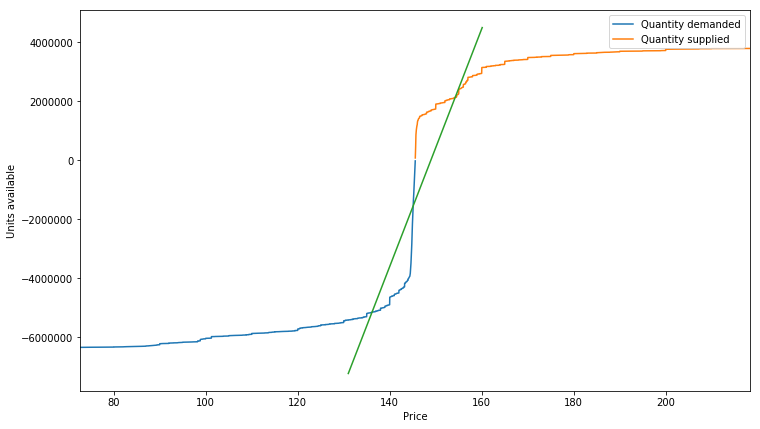

In [25]:
plot_orderbook(AAPL_orderbooks[-1])

Part 2)

In [10]:
def find_parameters(data):
    # Backs out the parameters we are interested in, given the parameters of the lienar regression
    # Finds parameters over time (for each individual orderbook)
    
    orderbooks = find_orderbooks(data)
    N = len(orderbooks)
    β_s = np.empty(N)
    γ_s = np.empty(N)
    p_stars = np.empty(N)

    for i, orderbook in enumerate(orderbooks):
        if i % 40 == 0:
            print(f'{i} of {N}')
        γ_s[i], β_s[i], p_stars[i] = estimate_equation(orderbook)
        
    print('Completed.')
    
    p_0 = -γ_s / β_s
    
    return p_0, β_s, p_stars  # β is equivalent to Σ

In [11]:
def plot_tickers(data, tickername):
    # Plots the relevant parameters over time
    
    p0, Σ, p_stars = find_parameters(data)

    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    fig.suptitle(f'Stock: {tickername}', y=1.02)

    axes[1].plot(p0 - p_stars)
    axes[1].set_ylabel('Difference between $p0$ and the midpoint')
    axes[1].set_xlabel('Time')

    axes[0].plot(Σ)
    axes[0].set_ylabel(r'Estimated value of $\frac{2 \sigma_u}{\sqrt{\Sigma_0}}$')
    axes[0].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

0 of 390
40 of 390
80 of 390
120 of 390
160 of 390
200 of 390
240 of 390
280 of 390
320 of 390
360 of 390
Completed.


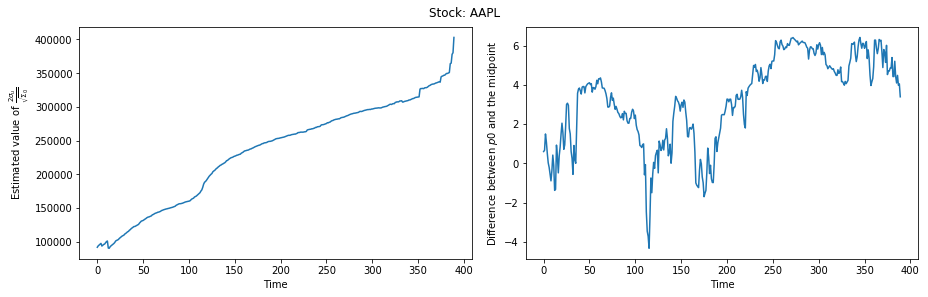

In [12]:
plot_tickers(AAPL, 'AAPL')

0 of 390
40 of 390
80 of 390
120 of 390
160 of 390
200 of 390
240 of 390
280 of 390
320 of 390
360 of 390
Completed.


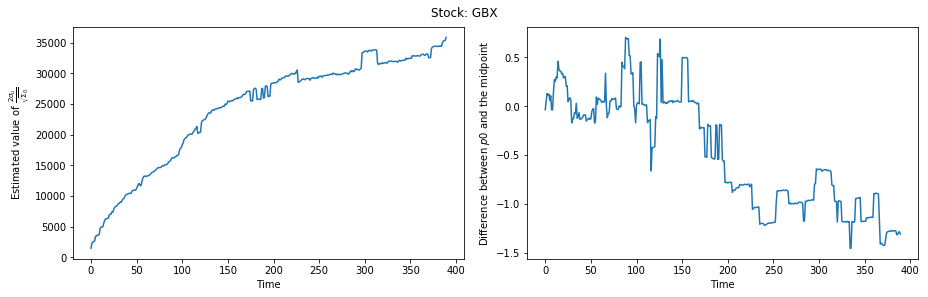

In [13]:
plot_tickers(GBX, 'GBX')

0 of 390
40 of 390
80 of 390
120 of 390
160 of 390
200 of 390
240 of 390
280 of 390
320 of 390
360 of 390
Completed.


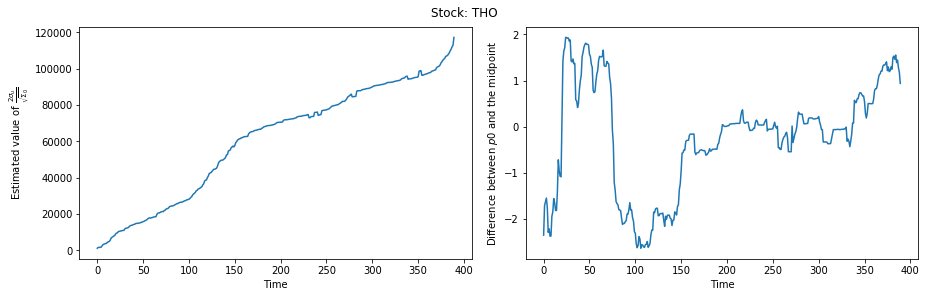

In [14]:
plot_tickers(THO, 'THO')

0 of 390
40 of 390
80 of 390
120 of 390
160 of 390
200 of 390
240 of 390
280 of 390
320 of 390
360 of 390
Completed.


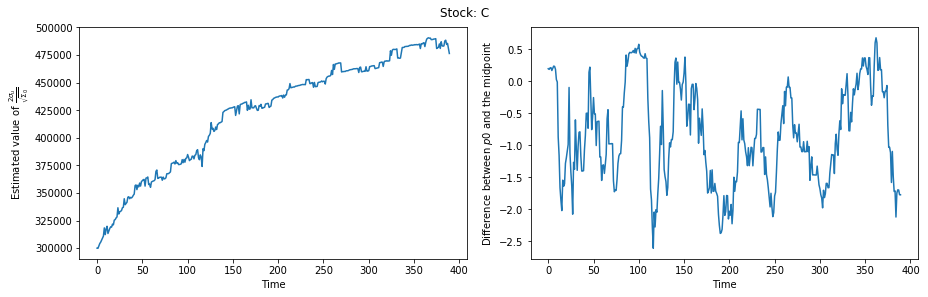

In [15]:
plot_tickers(C, 'C')

0 of 390
40 of 390
80 of 390
120 of 390
160 of 390
200 of 390
240 of 390
280 of 390
320 of 390
360 of 390
Completed.


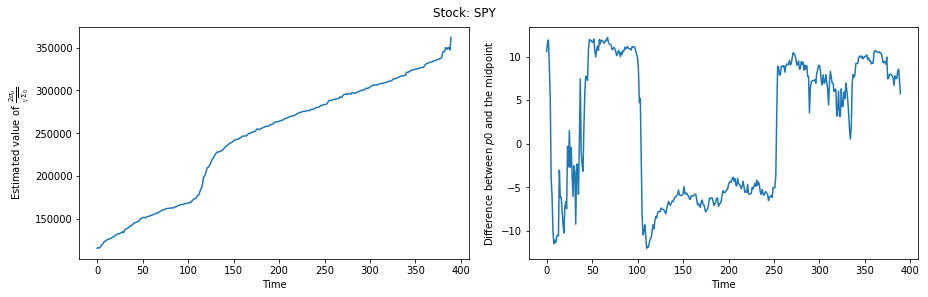

In [16]:
plot_tickers(SPY, 'SPY')

Market makers are more comfortable providing liquidity throughout the day. They provide more liquidity - acting as if ratio of uninformed to informed traders is going up.

Measure of how well line fits